# 🚢 Titanic Survival Prediction

**Goal:**  
Build a simple machine learning model that predicts the probability of survival for Titanic passengers using demographic and travel information.

**Dataset source:**  
[Kaggle Titanic: Machine Learning from Disaster](https://www.kaggle.com/datasets/yasserh/titanic-dataset?resource=download)

We will:
1. Load and explore the dataset.  
2. Clean missing data and engineer simple features.  
3. Train a Logistic Regression model.  
4. Expose a function `predict_survival()` that predicts survival probability for a given passenger.


In [20]:
# Setup imports, seed, and versions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, RocCurveDisplay)

np.random.seed(42)
print("pandas:", pd.__version__, "numpy:", np.__version__)

# Load dataset (assumes file named 'train.csv' in repo or same folder)
df = pd.read_csv("train.csv")  # replace path if needed
df.head()



pandas: 2.3.3 numpy: 2.3.3


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
df.info()
print("\nShape:", df.shape)
print("\nTarget distribution (Survived):")
print(df['Survived'].value_counts())
print("\nNormalized:")
print(df['Survived'].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Shape: (891, 12)

Target distribution (Survived):
Survived
0    549
1    342
Name: count, dtype: int64

Normalized:
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


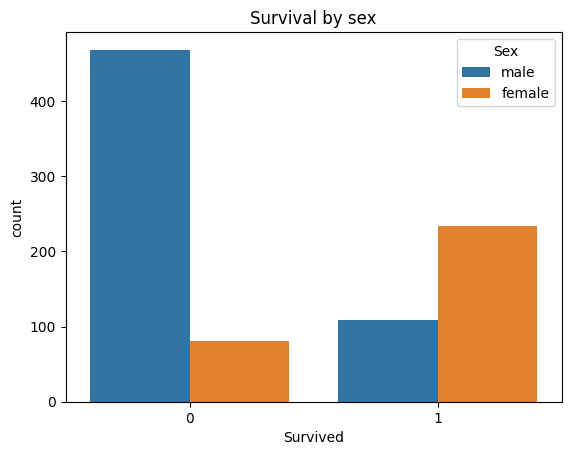

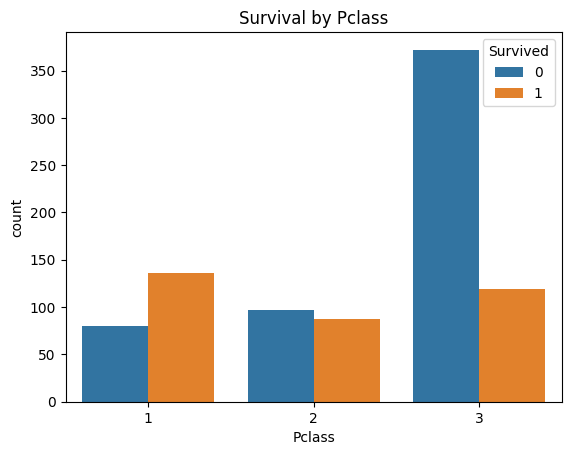

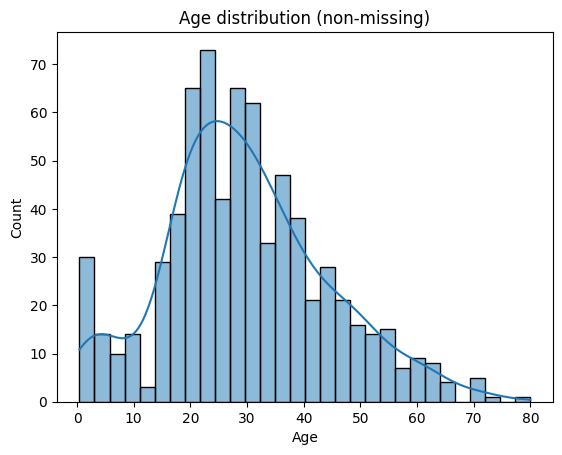

In [22]:
# Plots: survival by sex and Pclass and age distribution
sns.countplot(x='Survived', hue='Sex', data=df)
plt.title("Survival by sex")
plt.show()

sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title("Survival by Pclass")
plt.show()

plt.figure()
sns.histplot(df['Age'].dropna(), bins=30, kde=True)
plt.title("Age distribution (non-missing)")
plt.show()


In [23]:
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]


Cabin       687
Age         177
Embarked      2
dtype: int64

Planned simple features (3-6):
- Sex -> binary (male=1, female=0)
- Age -> fill missing with median, feature `IsChild` (Age < 12)
- FamilySize = SibSp + Parch + 1 (and small/large indicator)
- Title extracted from Name (Mr, Mrs, Miss, Master, Other)
- Fare -> log1p transform (or bucket later)
- Pclass -> treat as categorical (one-hot)
We will keep features compact for readability.


In [24]:
df_clean = df.copy()

# 1. Sex -> binary
df_clean['Sex'] = df_clean['Sex'].map({'male': 1, 'female': 0})

# 2. Title extraction
df_clean['Title'] = df_clean['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
df_clean['Title'] = df_clean['Title'].str.strip()
# Simplify titles
def simplify_title(t):
    if pd.isna(t): return 'Other'
    t = t.title()
    if t in ['Mr', 'Mrs', 'Miss', 'Master']:
        return t
    if t in ['Mlle','Ms']:
        return 'Miss'
    if t in ['Mme']:
        return 'Mrs'
    return 'Other'
df_clean['Title'] = df_clean['Title'].apply(simplify_title)

# 3. Family size
df_clean['FamilySize'] = df_clean['SibSp'] + df_clean['Parch'] + 1
df_clean['IsAlone'] = (df_clean['FamilySize'] == 1).astype(int)
df_clean['LargeFamily'] = (df_clean['FamilySize'] >= 5).astype(int)

# 4. Fare log transform - fill zeros if any then log1p
df_clean['Fare'] = df_clean['Fare'].fillna(0)
df_clean['Fare_log1p'] = np.log1p(df_clean['Fare'])

# 5. Age imputation handled in pipeline, but create IsChild for demonstration (use median to fill for now)
df_clean['Age'] = df_clean['Age'].fillna(df_clean['Age'].median())
df_clean['IsChild'] = (df_clean['Age'] < 12).astype(int)

# Drop unneeded columns for baseline
drop_cols = ['Cabin', 'Ticket', 'PassengerId', 'Name']
df_clean = df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns])

df_clean.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,LargeFamily,Fare_log1p,IsChild
0,0,3,1,22.0,1,0,7.2500,S,Mr,2,0,0,2.110213,0
1,1,1,0,38.0,1,0,71.2833,C,Mrs,2,0,0,4.280593,0
2,1,3,0,26.0,0,0,7.9250,S,Miss,1,1,0,2.188856,0
3,1,1,0,35.0,1,0,53.1000,S,Mrs,2,0,0,3.990834,0
4,0,3,1,35.0,0,0,8.0500,S,Mr,1,1,0,2.202765,0


In [27]:
# Select features to use (keeping it compact)
features = [
    'Pclass', 'Sex', 'Age', 'Fare_log1p', 'FamilySize', 'IsAlone', 'IsChild', 'Title', 'Embarked'
]

X = df_clean[features].copy()
y = df_clean['Survived'].copy()

# Simple check
X.head()


,Pclass,Sex,Age,Fare_log1p,FamilySize,IsAlone,IsChild,Title,Embarked
0,3,1,22.0,2.110213,2,0,0,Mr,S
1,1,0,38.0,4.280593,2,0,0,Mrs,C
2,3,0,26.0,2.188856,1,1,0,Miss,S
3,1,0,35.0,3.990834,2,0,0,Mrs,S
4,3,1,35.0,2.202765,1,1,0,Mr,S


In [28]:
# Train/test split (stratify to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (712, 9) Test: (179, 9)


In [29]:
# Preprocessing: separate numeric and categorical columns
numeric_features = ['Age', 'Fare_log1p', 'FamilySize']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['Pclass', 'Sex', 'IsAlone', 'IsChild', 'Title', 'Embarked']
# Note: Sex and Pclass are numeric-ish but treat as categorical to one-hot for interpretability
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='drop'
)


In [30]:
# Full pipeline with logistic regression
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

clf.fit(X_train, y_train)
print("Trained logistic regression pipeline.")


Trained logistic regression pipeline.


In [31]:
# Predict and probabilities
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.8379888268156425
Precision: 0.8125
Recall: 0.7536231884057971
F1: 0.7819548872180451
ROC AUC: 0.872463768115942


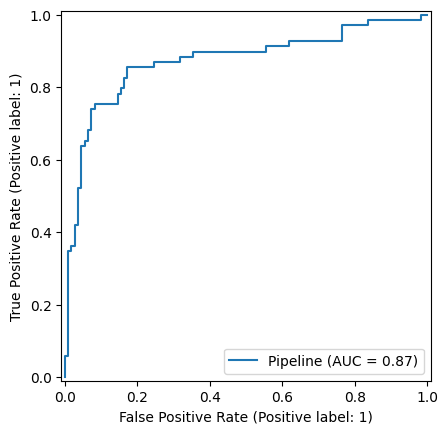

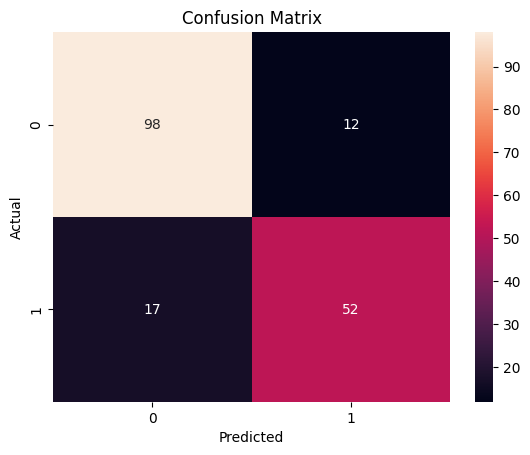

In [32]:
# ROC curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


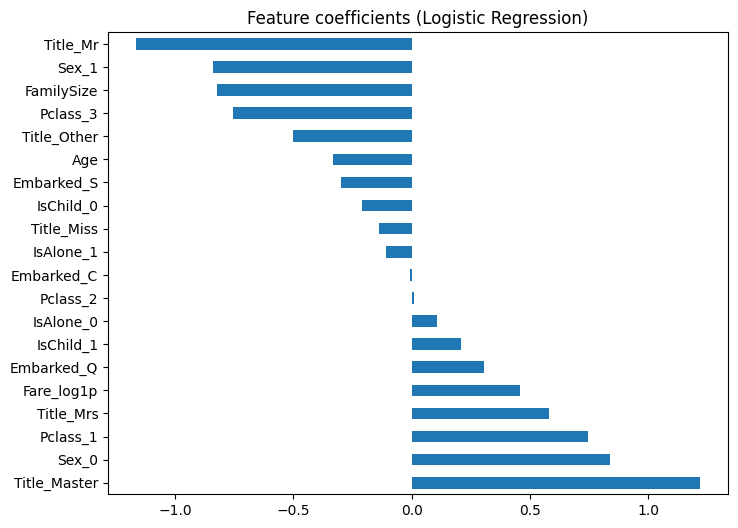

In [33]:
# Pull feature names after preprocessing
ohe = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
num_feature_names = numeric_features
feature_names = list(num_feature_names) + list(ohe_feature_names)

coefs = clf.named_steps['classifier'].coef_[0]
importance = pd.Series(coefs, index=feature_names).sort_values(ascending=False)
importance.plot(kind='barh', figsize=(8,6))
plt.title("Feature coefficients (Logistic Regression)")
plt.show()


In [34]:
# Save logistic pipeline (you can also save RF)
joblib.dump(clf, "logistic_pipeline.joblib")
# joblib.dump(rf_pipeline, "rf_pipeline.joblib")
print("Saved model to logistic_pipeline.joblib")


Saved model to logistic_pipeline.joblib


In [35]:
# Load (or use the already loaded clf)
model = clf  # or joblib.load("logistic_pipeline.joblib")

def predict_survival(pclass, sex, age, fare, sibsp, parch, embarked, title):
    """
    Return probability of survival (float 0-1)
    Input types:
    - pclass: int (1,2,3)
    - sex: 'male' or 'female'
    - age: float or int
    - fare: float
    - sibsp: int
    - parch: int
    - embarked: string 'C', 'Q', 'S'
    - title: one of ['Mr','Mrs','Miss','Master','Other']
    """
    sex_bin = 1 if sex.lower() == 'male' else 0
    fam_size = sibsp + parch + 1
    is_alone = 1 if fam_size == 1 else 0
    is_child = 1 if age < 12 else 0
    fare_log = np.log1p(fare if fare is not None else 0)
    row = {
        'Pclass': pclass,
        'Sex': sex_bin,
        'Age': age,
        'Fare_log1p': fare_log,
        'FamilySize': fam_size,
        'IsAlone': is_alone,
        'IsChild': is_child,
        'Title': title,
        'Embarked': embarked
    }
    df_row = pd.DataFrame([row])
    prob = model.predict_proba(df_row)[:, 1][0]
    return prob

# Examples
print("Example 1:", predict_survival(1, 'female', 60, 80, 0, 0, 'C', 'Mrs'))
print("Example 2:", predict_survival(3, 'male', 25, 7.25, 0, 0, 'S', 'Mr'))
print("Example 3:", predict_survival(2, 'male', 8, 12.5, 2, 1, 'S', 'Master'))


Example 1: 0.9510482251500054
Example 2: 0.0808974301321339
Example 3: 0.6114745471705616
